In [1]:
import os 

In [2]:
data = "datas\\names.txt" 
data_path = os.path.join(os.getcwd(),data)

In [3]:
text_data = open(data_path,"r").read().splitlines()
type(text_data)

list

In [4]:
chars   = sorted(list(set("".join(text_data))))
stoi    = {s:i+1 for i,s in enumerate(chars)} 
stoi["."] = 0
itos    = {s:i for i,s in sorted((stoi.items()))}

In [5]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt 

## Build dataset

In [6]:
def build_dataset(dataset:list=None,block_size:int=3):

    X,Y = [],[]
    for word in dataset:

        context = [0] * block_size
        for char in word +".":
            idx = stoi[char]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx] # crop and append
    
    X = torch.tensor(X,device="cuda")
    Y = torch.tensor(Y,device="cuda") 
    print(X.shape,Y.shape)
    return X,Y


random.seed(42)
random.shuffle(text_data,random=random.seed(42))
n1 = int(0.8 * len(text_data))
n2 = int(0.9 * len(text_data))

x_train,y_train = build_dataset(text_data[:n1])
x_val,y_val     = build_dataset(text_data[n1:n2])
x_test,y_test   = build_dataset(text_data[n2:]) 


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Neural Network

In [24]:
n_embd      = 10
n_hidden    = 200
block_size  = 3
vocab_size  = len(itos)


## initialize the parameters 
g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
C           = torch.randn((vocab_size,n_embd),                          generator=g,device="cuda:0")
w1          = torch.randn((n_embd * block_size,n_hidden),               generator=g,device="cuda:0")
b1          = torch.randn((n_hidden,),                                  generator=g,device="cuda:0")
w2          = torch.randn((n_hidden,vocab_size),                        generator=g,device="cuda:0")
b2          = torch.randn((vocab_size,),                                generator=g,device="cuda:0") 

parameters = [C,w1,b1,w2,b2]
print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")
for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11897


In [13]:
n_iter      = 100000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)
    h_act       = torch.tanh(h_preact)      # (32,200)

    logits      = h_act @ w2 + b2           # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    #backward pass
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 75000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())

      0/ 100000 :   28.5865
   1000/ 100000 :   8.2250
   2000/ 100000 :   7.5354
   3000/ 100000 :   5.4921
   4000/ 100000 :   3.8090
   5000/ 100000 :   3.5954
   6000/ 100000 :   4.6778
   7000/ 100000 :   4.3363
   8000/ 100000 :   3.0011
   9000/ 100000 :   2.9582
  10000/ 100000 :   4.2312
  11000/ 100000 :   4.1552
  12000/ 100000 :   2.8786
  13000/ 100000 :   3.8652
  14000/ 100000 :   2.9382
  15000/ 100000 :   3.1235
  16000/ 100000 :   2.4667
  17000/ 100000 :   3.9863
  18000/ 100000 :   3.2239
  19000/ 100000 :   2.1727
  20000/ 100000 :   2.4480
  21000/ 100000 :   3.4130
  22000/ 100000 :   3.3029
  23000/ 100000 :   2.3981
  24000/ 100000 :   2.2596
  25000/ 100000 :   2.6399
  26000/ 100000 :   2.6807
  27000/ 100000 :   2.6838
  28000/ 100000 :   3.4741
  29000/ 100000 :   1.9263
  30000/ 100000 :   2.8876
  31000/ 100000 :   3.3160
  32000/ 100000 :   2.3075
  33000/ 100000 :   2.2857
  34000/ 100000 :   2.6396
  35000/ 100000 :   2.6862
  36000/ 100000 :   2.3690


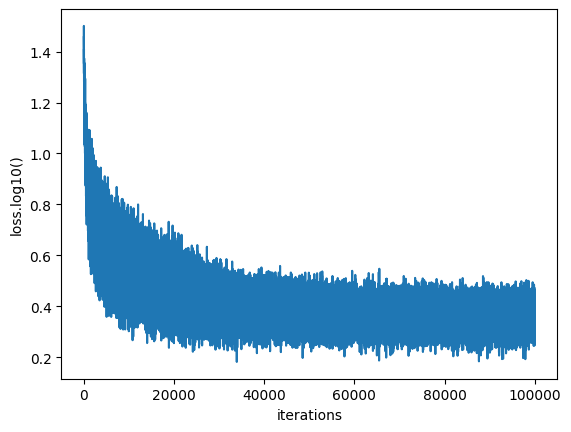

In [14]:
plt.plot((torch.tensor(loss_i).log10()))
plt.ylabel("loss.log10()")
plt.xlabel("iterations")
plt.show()

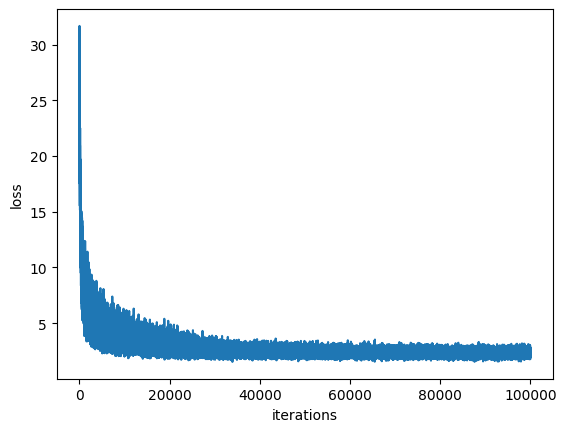

In [15]:
plt.plot(loss_i)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.show()

In [16]:
@torch.no_grad()       # this decorator disable gradient tracking, (no need to calulate during evaluation)
def split_loss(split):
    x,y = {
        "train" : (x_train,y_train),
        "val"   : (x_val,y_val),
        "test"  : (x_test,y_test)
    }[split]
    emb         = C[x]
    emb         = emb.view(emb.shape[0],-1) # (number_of_dataset, block_size * n_emb) (N, 3 * 10)
    h_preact    = emb @ w1 + b1             # (N,200)
    h_act       = torch.tanh(h_preact)      # (N,200)

    logits      = h_act @ w2 + b2           # (N,27)
    loss        = F.cross_entropy(logits,y) 
    print(split,loss.item())

split_loss("train")
split_loss("val")


train 2.31186842918396
val 2.323866844177246


In [17]:
g = torch.Generator(device="cuda").manual_seed(2147483647 + 10)

for _ in range(25):

    out     = []
    context = [0] * block_size 
    while True:
      emb     = C[torch.tensor([context])] 
      h       = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits  = h @ w2 + b2
      probs   = F.softmax(logits, dim=1)
      ix      = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))
    

bike.
sah.
zem.
deiryn.
jann.
rersheybelidzyomurah.
emi.
rayan.
adgedey.
quif.
mer.
tarelonni.
arstttely.
kedeendy.
marah.
aan.
juilana.
doria.
dareigh.
mabkelliso.
dertericbe.
nico.
mzam.
gie.
reigha.


## Fixing the initial loss 

The loss we get after model training.
- 0/ 200000 :   28.5865
- 25000/ 200000 :   2.6399
- 50000/ 200000 :   2.8675
- 75000/ 200000 :   1.9557
- 100000/ 200000 :   2.1587
- 125000/ 200000 :   2.7489
- 150000/ 200000 :   2.3592
- 175000/ 200000 :   2.4629

We can say that model is improperly configured at initialization. ie, from 1st iteration loss we get is around 28 and rapidly comes out around 1 to 2. Have multiple problems in initialization of model. 

1. Messed up Initialization :    Always have an rough idea for what loss to expect at inialization. At initialization what we have do that probability of each character (number of classes),(27 characters) consider as equal distribution. At initialization we have no reason to believe any characters have more likely than other character. So we expect probability distribution that comes out to be equal/uniform distribution.

    - Probability for any character = (1/27)        = 0.03703
    - Loss                          = -(prob.log()) = 3.2958<br>
- The loss we get by uniform distribution is much lower than what we get from initial initialization. 
- Initialize the parameters roughly zeros,logits do't have to be zeros they just have to be equal. 
    

In [18]:
## rough output from sample model, 
logits  = torch.tensor([0.1,0.1,0.1,0.1]) 
                                            # probs =  logits / logits.sum()  ======= alternate method of softmax. 
probs   = F.softmax(logits,dim=0)           # we got uniform distribution 0.25 for all data points. 
loss    = -probs[2].log()                   # 
logits,probs,loss


(tensor([0.1000, 0.1000, 0.1000, 0.1000]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [19]:
## rough output from sample model, 
logits  = torch.tensor([0.1,0.56,0.1,0.1]) 
                                            # probs =  logits / logits.sum()  ======= alternate method of softmax. 
probs   = F.softmax(logits,dim=0)           # we got uniform distribution 0.25 for all data points. 
loss    = -probs[1].log()                   # 
logits,probs,loss


# in this case for, getting 0.56 element from dataset and it's probability is 0.3465.actually 34.56%

(tensor([0.1000, 0.5600, 0.1000, 0.1000]),
 tensor([0.2181, 0.3456, 0.2181, 0.2181]),
 tensor(1.0626))

## Nudge the parameters

In [56]:
n_embd      = 10
n_hidden    = 200
block_size  = 3
vocab_size  = len(itos)


## initialize the parameters 
g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
C           = torch.randn((vocab_size,n_embd),                          generator=g,device="cuda:0")
w1          = torch.randn((n_embd * block_size,n_hidden),               generator=g,device="cuda:0")
b1          = torch.randn((n_hidden,),                                  generator=g,device="cuda:0") 
w2          = torch.randn((n_hidden,vocab_size),                        generator=g,device="cuda:0") * 0.01     # fixing the initial loss (logits)
b2          = torch.randn((vocab_size,),                                generator=g,device="cuda:0") * 0.0      # fixing the initial loss (logits)

parameters = [C,w1,b1,w2,b2]
print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")
for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11897


In [57]:
n_iter      = 100000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)
    h_act       = torch.tanh(h_preact)      # (32,200)

    logits      = h_act @ w2 + b2           # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    #backward pass
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 75000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())


      0/ 100000 :   3.3238
  10000/ 100000 :   2.6354
  20000/ 100000 :   2.0343
  30000/ 100000 :   2.3747
  40000/ 100000 :   2.1267
  50000/ 100000 :   2.4670
  60000/ 100000 :   2.3716
  70000/ 100000 :   2.2068
  80000/ 100000 :   2.1845
  90000/ 100000 :   2.0451


The logits are getting on 0 th elements are quite extreme values. That why its creating extreme loss value (28). Lets try it to make it logits approximatly/closer to zero. 

## 1. logits = w2 @ h_act + b2. we need to make logits to closer to zero.

- Make the logits closer to zero at initialization 
    - b2 = 0 
    - w2 ~ closer to  zero. scale down w2 by 0.1 all the elements. 
    - By doing that we get loss = 4.28, but we want closer to loss (uniform distribution loss = 3.2958)
    - w2, scale down  by 0.01, ==>> loss we get closer to 3.2958.<br>

    
- Why we can't set w2 = 0 ???
    1. Symmetry Problem in Neural Networks
    
        - Identical Neuron Behavior:
            - Each neuron has weights that are updated during training. If all weights are initialized to zero, all neurons in a layer will compute the same output, leading to identical gradients during backpropagation.
        - No Diversity in Learning:
            - Because the neurons start with identical weights, they will learn the same features and update identically during training. This prevents the network from learning diverse and complex features, limiting its overall capacity and performance.

    2. No Gradient Flow for Zero Initialization

        - Gradient Descent: 
            - In gradient descent, weights are updated based on the gradient of the loss function with respect to the weights. If weights are initialized to zero, the gradients might also be zero for certain activation functions (like ReLU), causing the weights to remain zero, which halts learning altogether.
        - Dead Neurons:
            -  In the case of activation functions like ReLU, if the input to the neuron is zero, the gradient can be zero as well, leading to "dead neurons" that no longer update, further impairing the network's ability to learn.

    3. Bias Term Doesn't Learn Properly

        Bias Needs Flexibility: The bias term in a model helps shift the activation function, allowing the model to fit data better. Initializing weights to zero can prevent the bias from properly influencing the model, leading to a less effective model.

    4. Optimization Difficulty

        Poor Convergence: Zero initialization can lead to poor convergence in optimization algorithms like gradient descent. The weights might either converge very slowly or get stuck in suboptimal points because the gradient provides no meaningful direction to move towards.
        Flat Loss Surface: With zero initialization, the loss surface might become flat, meaning that the model struggles to find gradients that lead to an optimal solution.




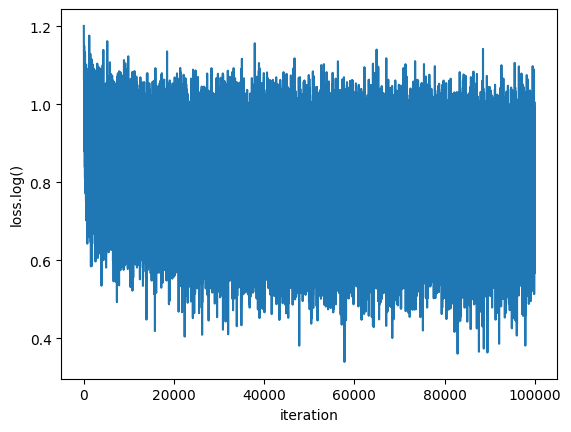

In [65]:
plt.plot(torch.tensor(loss_i).log())
plt.xlabel("iteration")
plt.ylabel("loss.log()")
plt.show()

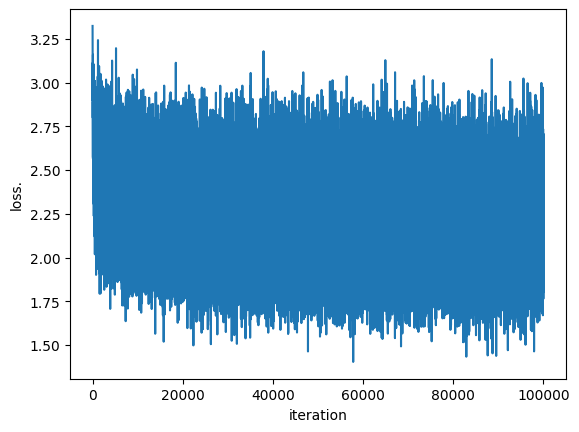

In [67]:
plt.plot(torch.tensor(loss_i))
plt.xlabel("iteration")
plt.ylabel("loss.")
plt.show()

In [ ]:
split_loss("train")
split_loss("val")

## 2. Fixing the Saturated Tanh()

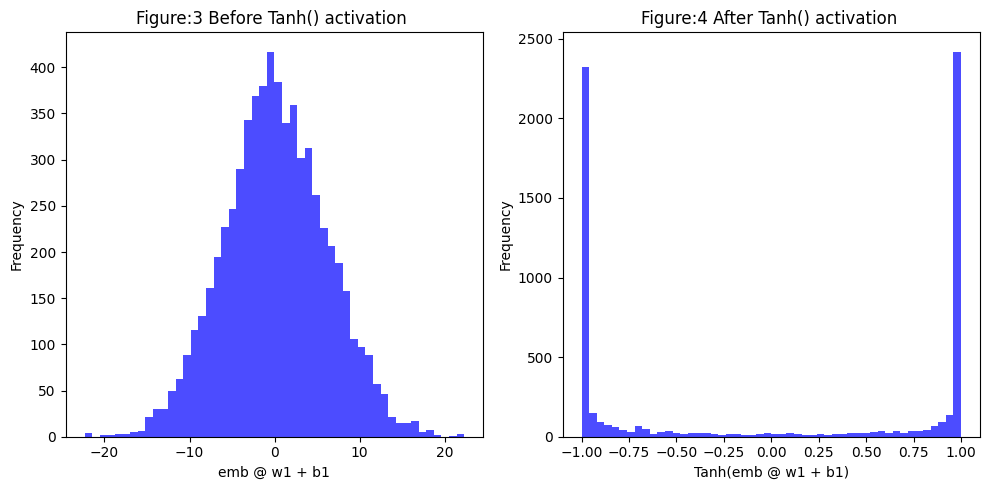

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first histogram
axs[0].hist(h_preact.flatten().tolist(),bins=50, color='blue', alpha=0.7)
axs[0].set_title('Figure:3 Before Tanh() activation ')
axs[0].set_xlabel('emb @ w1 + b1')
axs[0].set_ylabel('Frequency')

# Plot the second histogram
axs[1].hist(h_act.flatten().tolist(),bins=50, color='blue', alpha=0.7)
axs[1].set_title('Figure:4 After Tanh() activation ')
axs[1].set_xlabel('Tanh(emb @ w1 + b1)')
axs[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

From the graph we can see Tanh() funciton is strong,ie (value -1 and 1)
```def tanh(self.data):
    x = data
    t = math.exp(2x) - 1 / math.exp(2x) + 1 
    out = Value(t,(self,)"tanh")
    
    def _backward():
        self.grad += (1 - t**2) * out.grad```


1. case 1 : if we get tanh(x) = 1
    self.grad +=  (1 - 1**2 ) * out./grad = 0. 

    Vanishing gradient = In this case the model literally learn nothing. 

2. case 2 : if we get tanh(x) = -1
    self.grad +=  (1 - -1**2 ) * out./grad = 2 * out.grad.     

    gradient explosion = In this case the model cannot learn nothing over the deap of NN layers. 


In the both end of Tanh() value, we have no control over it, because when ever we want to change the parameters , it doesn't have any impact on loss. 

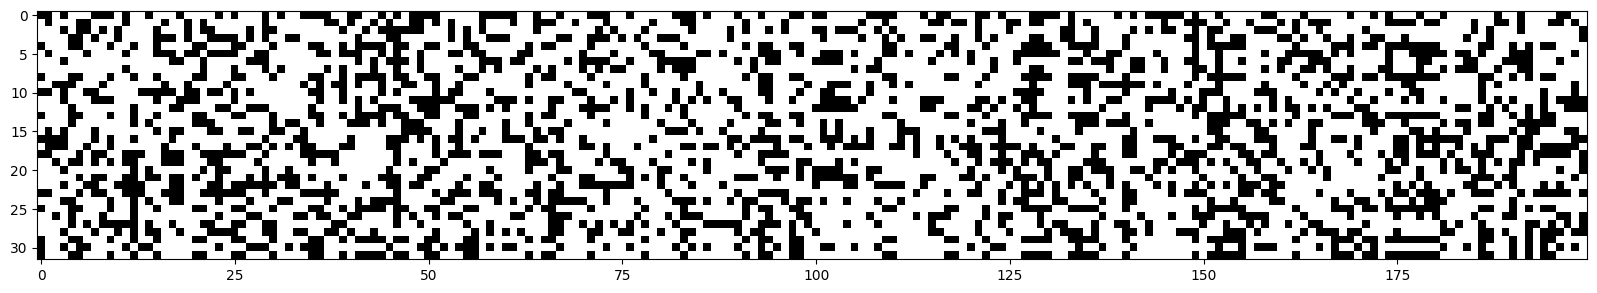

In [139]:
plt.figure(figsize=(20,10))
plt.imshow(h_act.cpu().detach().abs()>0.99,cmap="gray",interpolation="nearest");

This above graph representing True False statement. The graph representing relationship between neurons (200) and datas (32). The black representing False and white representing white one. 

- White - all the tanh neurons are highly active (flat tail),**(highly active means closer to 1)** In all these point we get gradient would be destroyed.
    - If the all column in perticular neuron is white it's meaning that the neuron is dead. (neuron where initialization of **w and b** never ever bought into activate). 


- Note: if gradient is zero, that means the neuron is dead. IF no datas ever activates its neuron, so neuron remain forever (permanent brain damage )

![](https://www.oreilly.com/api/v2/epubs/9781788472173/files/assets/7f566009-af69-4eea-b244-014c5fc4fc19.png)


In [190]:
def find_dead_neuron(threshold:float=0.99,dead_neuron_percentage:float=0.75):
    above_threshold             = h_act > threshold
    percentage_above_threshold  = torch.mean(above_threshold.float(),dim=0)
    #Check if any neuron has dead_neuron % or more of its outputs above 0.99
    threshold_check = percentage_above_threshold >= dead_neuron_percentage
    if torch.any(threshold_check):
        print(f"At least one neuron has {dead_neuron_percentage}% or more of its outputs above {threshold}.")
    else:
        print(f"No neuron has {dead_neuron_percentage}% or more of its outputs above {threshold}.")

    # Optionally, get the indices of neurons that satisfy this condition
    neuron_indices = torch.nonzero(threshold_check).squeeze()
    print("Dead neuron indices:", neuron_indices.tolist())

In [191]:
find_dead_neuron()

At least one neuron has 0.75% or more of its outputs above 0.99.
Dead neuron indices: [10, 85, 87, 99, 119, 142, 193]


In [192]:
n_embd      = 10
n_hidden    = 200
block_size  = 3
vocab_size  = len(itos)


## initialize the parameters 
g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
C           = torch.randn((vocab_size,n_embd),                          generator=g,device="cuda:0")
w1          = torch.randn((n_embd * block_size,n_hidden),               generator=g,device="cuda:0") * 0.2
b1          = torch.randn((n_hidden,),                                  generator=g,device="cuda:0") * 0.01
w2          = torch.randn((n_hidden,vocab_size),                        generator=g,device="cuda:0") * 0.01     # fixing the initial loss (logits)
b2          = torch.randn((vocab_size,),                                generator=g,device="cuda:0") * 0.0      # fixing the initial loss (logits)

parameters = [C,w1,b1,w2,b2]
print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")
for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11897


In [193]:
n_iter      = 100000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)
    h_act       = torch.tanh(h_preact)      # (32,200)

    logits      = h_act @ w2 + b2           # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    #backward pass
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 75000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())


      0/ 100000 :   3.3121
  10000/ 100000 :   2.6772
  20000/ 100000 :   2.0480
  30000/ 100000 :   2.2795
  40000/ 100000 :   2.1517
  50000/ 100000 :   2.5262
  60000/ 100000 :   2.3401
  70000/ 100000 :   2.1950
  80000/ 100000 :   2.1777
  90000/ 100000 :   2.0184


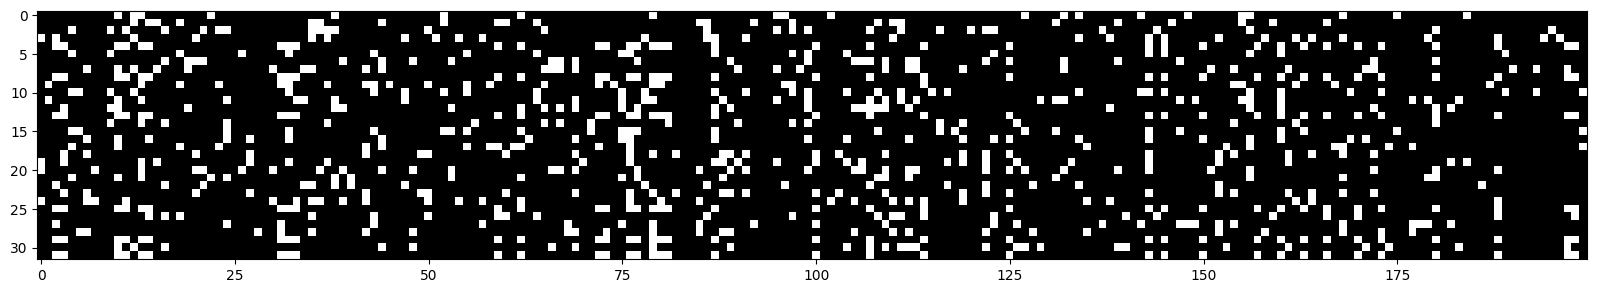

In [208]:
plt.figure(figsize=(20,10))
plt.imshow(h_act.cpu().detach().abs()>0.99,cmap="gray",interpolation="nearest");

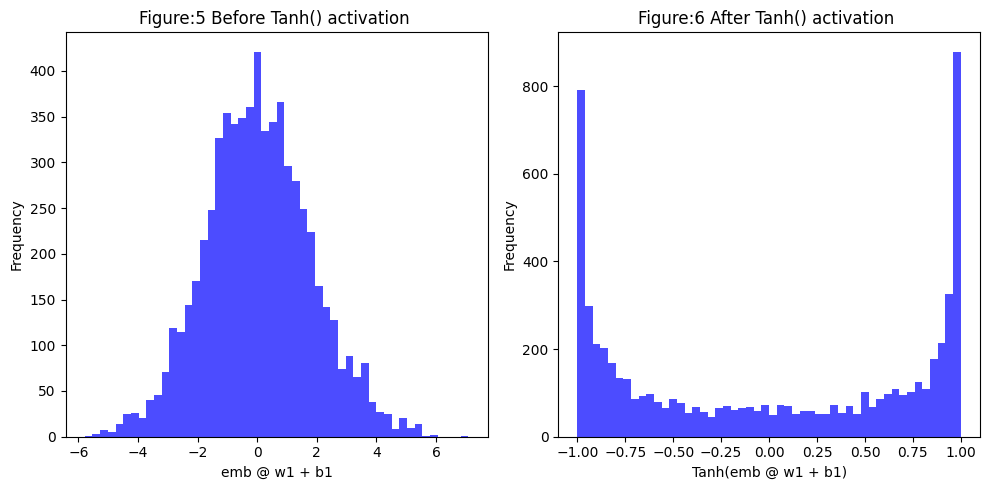

In [194]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first histogram
axs[0].hist(h_preact.flatten().tolist(),bins=50, color='blue', alpha=0.7)
axs[0].set_title('Figure:5 Before Tanh() activation ')
axs[0].set_xlabel('emb @ w1 + b1')
axs[0].set_ylabel('Frequency')

# Plot the second histogram
axs[1].hist(h_act.flatten().tolist(),bins=50, color='blue', alpha=0.7)
axs[1].set_title('Figure:6 After Tanh() activation ')
axs[1].set_xlabel('Tanh(emb @ w1 + b1)')
axs[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

In [207]:
find_dead_neuron(dead_neuron_percentage=0.4)

At least one neuron has 0.4% or more of its outputs above 0.99.
Dead neuron indices: [10, 76, 87]


In [209]:
split_loss("train")
split_loss("val")

train 2.1436328887939453
val 2.1678433418273926


## He_normalization